# Ceramic Dataset
## Define functions and imports

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from skimage import io
from skimage import filters
import glob
import spectral.io.envi as envi
import numpy as np
import cv2
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
from matplotlib.lines import Line2D

In [5]:
def openHDR2(hdrImage, mainImage, mask, window, paperMask, paperWindow, usePaperCalibration = True):
    img = envi.open(hdrImage)#, mainImage
    Darkref = envi.open("./Ceramica/BW_Reference/capture/DARKREF_Im_ceramica_2020-12-15_14-54-13.hdr",
                        "./Ceramica/BW_Reference/capture/DARKREF_Im_ceramica_2020-12-15_14-54-13.raw")
    Whiteref = envi.open("./Ceramica/BW_Reference/capture/WHITEREF_Im_ceramica_2020-12-15_14-54-13.hdr",
                         "./Ceramica/BW_Reference/capture/WHITEREF_Im_ceramica_2020-12-15_14-54-13.raw")

    Darkref = np.repeat(Darkref[:,:,:],10, axis=0)
    Whiteref = np.repeat(Whiteref[:,:,:],10, axis=0)
    imgArray = img[:,:,:]
    
    PaperDark = Darkref[np.nonzero(paperMask)]
    PaperWhite =Whiteref[np.nonzero(paperMask)]
    Paper = ((imgArray[np.nonzero(paperMask)] - PaperDark)/(PaperWhite - PaperDark ))
    Paper = Paper.reshape(-1, Paper.shape[-1])
    paperMean = np.array([np.mean(Paper[:,x]) for x in range(Paper.shape[1])])
    #passar papermean a array imatge
    #paperStd = np.array([np.std(Paper[:,x]) for x in range(Paper.shape[1])])
    #pixelValues = np.empty((0,224))
    
    Image = imgArray[np.nonzero(mask)]
    Dark = Darkref[np.nonzero(mask)]#[topLeft[0]:bottomRight[0],topLeft[1]:bottomRight[1],:]
    White = Whiteref[np.nonzero(mask)]
    Reflectancia = ((Image - Dark)/(White - Dark ))
    #yMiddle = Reflectancia.shape[0]//2
    #xMiddle = Reflectancia.shape[1]//2
    #window=corner[2]
    #windowArea = Reflectancia[yMiddle-window:yMiddle+window,xMiddle-window:xMiddle+window,:]
    #windowArea = windowArea.reshape(-1, windowArea.shape[-1])
    Reflectancia = Reflectancia.reshape(-1, Reflectancia.shape[-1])
    #pixelValues = np.concatenate((pixelValues,Reflectancia))
    histogramMean = None
    histogramStd = None
    if usePaperCalibration:
        histogramMean = ([np.mean(Reflectancia[:,x]/paperMean[x]) for x in range(Reflectancia.shape[1])],img.bands.centers)
        histogramStd = [np.std(Reflectancia[:,x]/paperMean[x]) for x in range(Reflectancia.shape[1])]
    else:
        histogramMean = ([np.mean(Reflectancia[:,x]) for x in range(Reflectancia.shape[1])],img.bands.centers)
        histogramStd = [np.std(Reflectancia[:,x]) for x in range(Reflectancia.shape[1])]
    return histogramMean, histogramStd, Reflectancia#,paperMean,paperStd

In [6]:
def openHDR(hdrImage, mainImage, mask, window, paperMask, paperWindow, usePaperCalibration = True):
    img = envi.open(hdrImage)#, mainImage
    Darkref = envi.open("./Ceramica/BW_Reference/capture/DARKREF_Im_ceramica_2020-12-15_14-54-13.hdr",
                        "./Ceramica/BW_Reference/capture/DARKREF_Im_ceramica_2020-12-15_14-54-13.raw")
    Whiteref = envi.open("./Ceramica/BW_Reference/capture/WHITEREF_Im_ceramica_2020-12-15_14-54-13.hdr",
                         "./Ceramica/BW_Reference/capture/WHITEREF_Im_ceramica_2020-12-15_14-54-13.raw")

    Darkref = np.repeat(Darkref[:,:,:],10, axis=0)
    Whiteref = np.repeat(Whiteref[:,:,:],10, axis=0)
    imgArray = img[:,:,:]
    
    PaperDark = Darkref[np.nonzero(paperMask)]
    PaperWhite =Whiteref[np.nonzero(paperMask)]
    Paper = ((imgArray[np.nonzero(paperMask)] - PaperDark)/(PaperWhite - PaperDark ))
    Paper = Paper.reshape(-1, Paper.shape[-1])
    paperMean = np.array([np.mean(Paper[:,x]) for x in range(Paper.shape[1])])
    #paperStd = np.array([np.std(Paper[:,x]) for x in range(Paper.shape[1])])
    #pixelValues = np.empty((0,224))
    
    Image = imgArray[np.nonzero(mask)]
    Dark = Darkref[np.nonzero(mask)]#[topLeft[0]:bottomRight[0],topLeft[1]:bottomRight[1],:]
    White = Whiteref[np.nonzero(mask)]
    Reflectancia = ((Image - Dark)/(White - Dark ))
    #yMiddle = Reflectancia.shape[0]//2
    #xMiddle = Reflectancia.shape[1]//2
    #window=corner[2]
    #windowArea = Reflectancia[yMiddle-window:yMiddle+window,xMiddle-window:xMiddle+window,:]
    #windowArea = windowArea.reshape(-1, windowArea.shape[-1])
    Reflectancia = Reflectancia.reshape(-1, Reflectancia.shape[-1])
    #pixelValues = np.concatenate((pixelValues,Reflectancia))
    histogramMean = None
    histogramStd = None
    if usePaperCalibration:
        histogramMean = ([np.mean(Reflectancia[:,x]/paperMean[x]) for x in range(Reflectancia.shape[1])],img.bands.centers)
        histogramStd = [np.std(Reflectancia[:,x]/paperMean[x]) for x in range(Reflectancia.shape[1])]
    else:
        histogramMean = ([np.mean(Reflectancia[:,x]) for x in range(Reflectancia.shape[1])],img.bands.centers)
        histogramStd = [np.std(Reflectancia[:,x]) for x in range(Reflectancia.shape[1])]
    return histogramMean, histogramStd, Reflectancia#,paperMean,paperStd

In [7]:
def getMaskPaper(hsvImage,otsu):
    #hsvImage = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    #hsvImage[:,:110,2] = 0
    #hsvImage[:,475:,2] = 0
    #otsu = filters.threshold_otsu(hsvImage[:,:,2])
    mask = hsvImage[:,:,2]>otsu*1.25
    mask = mask * hsvImage[:,:,0]>60
    #plt.imshow(hsvImage[:,:,1]<20)
    #plt.show()
    #mask = mask * hsvImage[:,:,1]<20
    mask[:,:110] = 0
    mask[:,475:] = 0
    kernel = np.ones((5,5),np.uint8)
    #mask = cv2.morphologyEx(np.float32(mask), cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(np.float32(mask), cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(np.float32(mask), cv2.MORPH_ERODE, kernel)
    mask = cv2.morphologyEx(np.float32(mask), cv2.MORPH_ERODE, kernel)
    mask = cv2.morphologyEx(np.float32(mask), cv2.MORPH_ERODE, kernel)
    #plt.figure(figsize=(24,16), dpi= 100, facecolor='w', edgecolor='k')
    return mask
    num_labels, labels_im = cv2.connectedComponents(np.uint8(mask),connectivity=8)
    boundingBoxes=[]
    for i in range(1,num_labels):
        section = labels_im[:,:]==i
        rows = np.any(section, axis=1)
        cols = np.any(section, axis=0)
        rmin, rmax = np.where(rows)[0][[0, -1]]
        cmin, cmax = np.where(cols)[0][[0, -1]]
        boundingBox=((rmin,cmin),(rmax,cmax),min((cmax-cmin)//3,(rmax-rmin)//3),(cmax-cmin)*(rmax-rmin))
        if cmax-cmin > 20 and rmax-rmin >20 and cmax-cmin < 60 and rmax-rmin <40:
            #print(boundingBox)
            boundingBoxes.append(boundingBox)
            #plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
            #plt.imshow(section)
            #plt.show()
    boundingBoxes = sorted(boundingBoxes, key = lambda x: x[3])
    return boundingBoxes[-1]

In [8]:
def getMaskPieces(hsvImage,otsu):
    hsvImage[:,:,0] = hsvImage[:,:,0]<40
    hsvImage[:,:,2] = hsvImage[:,:,2]>otsu*0.2
    hsvImage[:,:,2] = hsvImage[:,:,2]<otsu*0.75
    
    mask = hsvImage[:,:,0]*hsvImage[:,:,2]*hsvImage[:,:,1]>40
    mask[:,:110] = 0
    mask[:,475:] = 0
    
    kernel = np.ones((7,7),np.uint8)
    mask = cv2.morphologyEx(np.float32(mask), cv2.MORPH_CLOSE, kernel)
    kernel = np.ones((5,5),np.uint8)
    #mask = cv2.morphologyEx(np.float32(mask), cv2.MORPH_OPEN, kernel)
    
    #kernel = np.ones((3,3),np.uint8)
    mask = cv2.morphologyEx(np.float32(mask), cv2.MORPH_ERODE, kernel)
    return mask
    #plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
    #plt.imshow(mask)
    #plt.show()
    num_labels, labels_im = cv2.connectedComponents(np.uint8(mask),connectivity=8)
    boundingBoxes=[]
    for i in range(1,num_labels):
        section = labels_im[:,:]==i
        rows = np.any(section, axis=1)
        cols = np.any(section, axis=0)
        rmin, rmax = np.where(rows)[0][[0, -1]]
        cmin, cmax = np.where(cols)[0][[0, -1]]
        boundingBox=((rmin,cmin),(rmax,cmax),min((cmax-cmin)//8,(rmax-rmin)//8))
        if cmax-cmin > 10 and rmax-rmin >10:
            #print(boundingBox)
            boundingBoxes.append(boundingBox)
            #plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
            #plt.imshow(section)
            #plt.show()
    #plt.show()
    

In [9]:
def openAndCrop(folderPath, paperWindow=7, window = 5, usePaperCalibration = True, showImages=True):#, corners, paperTopLeft, paperBottomRight
    imagePath = glob.glob(folderPath+'*.png')[0].replace('\\','/')
    hdrImage = glob.glob(folderPath+'*capture/*.hdr')[0].replace('\\','/')
    image = io.imread(imagePath)
    
    
    hsvImage = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsvImage[:,:110,2] = 0
    hsvImage[:,475:,2] = 0
    otsu = filters.threshold_otsu(hsvImage[:,:,2])
    mask = getMaskPieces(hsvImage.copy(),otsu)
    inverseMask = np.ones(mask.shape)-mask
    paperMask = getMaskPaper(hsvImage.copy(),otsu)
    paperMask = paperMask * inverseMask
    
    #paperTopLeft = paperCorners[0]
    #paperBottomRight = paperCorners[1]
    
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    cropImage = image.copy()
    cropImage[np.nonzero(mask)] = [255,0,0]
    cropImage = cropImage[rmin-5:rmax+5,cmin-5:cmax+5]
    
    rows = np.any(paperMask, axis=1)
    cols = np.any(paperMask, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    paperImage = image.copy()
    paperImage[np.nonzero(paperMask)] = [0,255,0]
    paperImage = paperImage[rmin-5:rmax+5,cmin-5:cmax+5]
    histogram, std, values = openHDR(hdrImage, imagePath, mask, window, paperMask, paperWindow)#,paperMean,paperStd
    xValues = histogram[1]
    mean = np.array(histogram[0])
    std = np.array(std)
    
    if showImages:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=False, figsize=(9,3))#, ax5
        ax1.imshow(image)
        #for corner in corners:
            #topLeft = corner[0]
            #bottomRight = corner[1]
            #rect = patches.Rectangle((topLeft[1],topLeft[0]),(bottomRight[1]-topLeft[1]),(bottomRight[0]-topLeft[0]),linewidth=1,edgecolor='r',facecolor='none')
            #ax1.add_patch(rect)
        #rect = patches.Rectangle((paperTopLeft[1],paperTopLeft[0]),(paperBottomRight[1]-paperTopLeft[1]),(paperBottomRight[0]-paperTopLeft[0]),linewidth=1,edgecolor='g',facecolor='none')
        #ax1.add_patch(rect)

       # yMiddle = cropImage.shape[0]//2
       # xMiddle = cropImage.shape[1]//2
        #rect = patches.Rectangle((xMiddle-corners[0][2],yMiddle-corners[0][2]),(2*corners[0][2]),(2*corners[0][2]),linewidth=1,edgecolor='r',facecolor='none')
        #ax2.add_patch(rect)
        ax2.imshow(cropImage)
        
        ax3.imshow(paperImage)
        #yMiddle = paperImage.shape[0]//2
        #xMiddle = paperImage.shape[1]//2
        #rect = patches.Rectangle((xMiddle-paperWindow,yMiddle-paperWindow),(2*paperWindow),(2*paperWindow),linewidth=1,edgecolor='g',facecolor='none')
        #ax3.add_patch(rect)
        ax4.plot(xValues,mean)
        ax4.fill_between(xValues,mean-std, mean+std,alpha=0.2)
        ax4.set_ylim([0,1])
        ax4.set_xlabel("Wavelength(nm)")
        ax4.set_ylabel("Reflectance")
        
        #ax5.plot(xValues,paperMean)
        #ax5.fill_between(xValues,paperMean-paperStd, paperMean+paperStd,alpha=0.2)
        #ax5.set_ylim([0,1])
        #ax5.set_xlabel("Wavelength(nm)")
        #ax5.set_ylabel("Reflectance")
        
        ax1.set_anchor("S")
        ax2.set_anchor("S")
        ax3.set_anchor("S")
        ax4.set_anchor("S")
        #ax5.set_anchor("S")
        
        
        
        fig.suptitle(folderPath.split('/')[-3])
        plt.subplots_adjust(wspace = 0.4,bottom = 0.1)
        plt.show()
         
    return [xValues, mean, std,values]

## Image Samples
Some samples from each category of ceramics are shown here, as a first step towards the visualization of differences between the histograms of different categories

In [10]:
histograms = []

### Ancient ceramics (2 samples)

C:\Users\pcano\Anaconda3\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


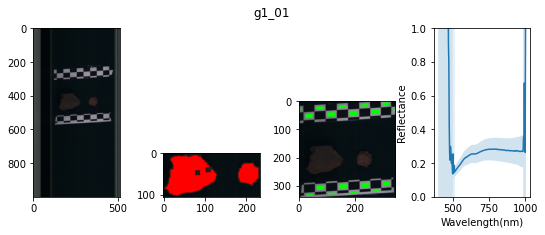

[397.66, 400.28, 402.9, 405.52, 408.13, 410.75, 413.37, 416.0, 418.62, 421.24, 423.86, 426.49, 429.12, 431.74, 434.37, 437.0, 439.63, 442.26, 444.89, 447.52, 450.16, 452.79, 455.43, 458.06, 460.7, 463.34, 465.98, 468.62, 471.26, 473.9, 476.54, 479.18, 481.83, 484.47, 487.12, 489.77, 492.42, 495.07, 497.72, 500.37, 503.02, 505.67, 508.32, 510.98, 513.63, 516.29, 518.95, 521.61, 524.27, 526.93, 529.59, 532.25, 534.91, 537.57, 540.24, 542.91, 545.57, 548.24, 550.91, 553.58, 556.25, 558.92, 561.59, 564.26, 566.94, 569.61, 572.29, 574.96, 577.64, 580.32, 583.0, 585.68, 588.36, 591.04, 593.73, 596.41, 599.1, 601.78, 604.47, 607.16, 609.85, 612.53, 615.23, 617.92, 620.61, 623.3, 626.0, 628.69, 631.39, 634.08, 636.78, 639.48, 642.18, 644.88, 647.58, 650.29, 652.99, 655.69, 658.4, 661.1, 663.81, 666.52, 669.23, 671.94, 674.65, 677.36, 680.07, 682.79, 685.5, 688.22, 690.93, 693.65, 696.37, 699.09, 701.81, 704.53, 707.25, 709.97, 712.7, 715.42, 718.15, 720.87, 723.6, 726.33, 729.06, 731.79, 734.5

In [11]:
histograms.append(openAndCrop("./Ceramica/g1/g1_01/1_A/"))

C:\Users\pcano\Anaconda3\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


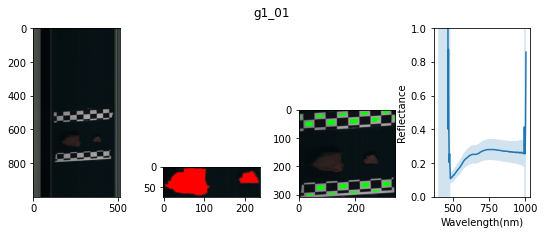

In [8]:
histograms.append(openAndCrop("./Ceramica/g1/g1_01/1_B/"))

### Tardoantiguitat (1 sample)

C:\Users\pcano\Anaconda3\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


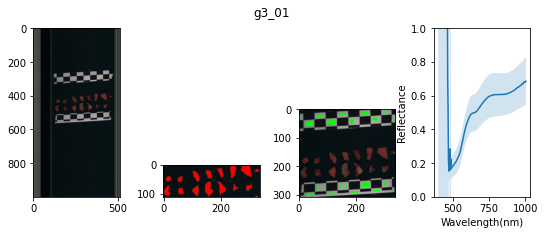

In [9]:
histograms.append(openAndCrop("./Ceramica/g3/g3_01/1_A/"))

### Commune amphorae (1 sample)

C:\Users\pcano\Anaconda3\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


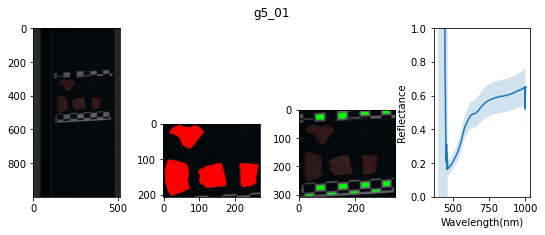

In [10]:
histograms.append(openAndCrop("./Ceramica/g5/g5_01/1_A/"))

### African commune ceramics (1 sample)

C:\Users\pcano\Anaconda3\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


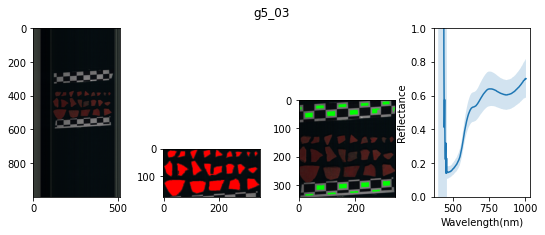

In [11]:
histograms.append(openAndCrop("./Ceramica/g5/g5_03/2_A/"))

### Local commune ceramics (1 sample)

C:\Users\pcano\Anaconda3\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


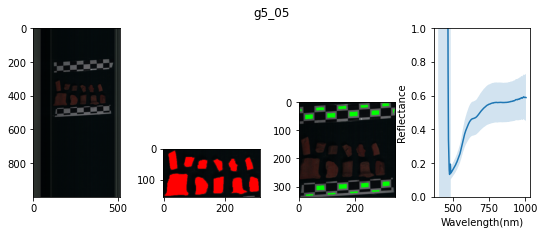

In [12]:
histograms.append(openAndCrop("./Ceramica/g5/g5_05/2_A/"))

### Iberic ceramics (1 sample)

C:\Users\pcano\Anaconda3\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


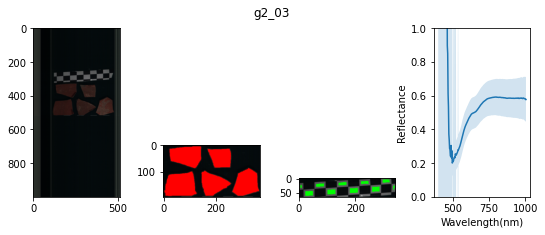

In [13]:
histograms.append(openAndCrop("./Ceramica/g2/g2_03/1_A/"))

### Roman amphorae

C:\Users\pcano\Anaconda3\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


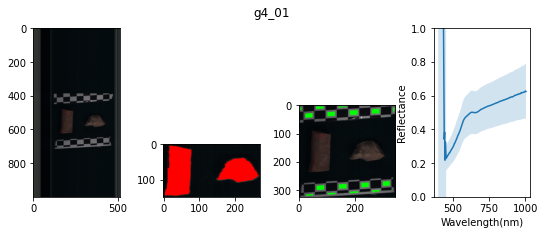

In [14]:
histograms.append(openAndCrop("./Ceramica/g4/g4_01/1_A/"))

C:\Users\pcano\Anaconda3\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


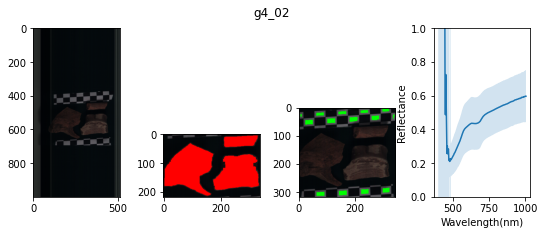

In [15]:
histograms.append(openAndCrop("./Ceramica/g4/g4_02/1_A/"))

C:\Users\pcano\Anaconda3\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


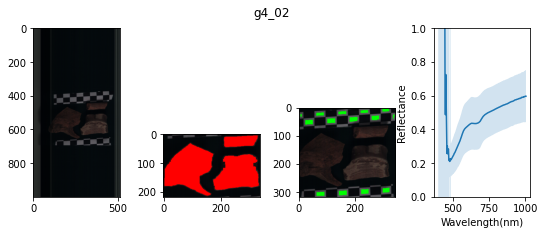

In [16]:
histograms.append(openAndCrop("./Ceramica/g4/g4_02/1_A/"))

C:\Users\pcano\Anaconda3\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


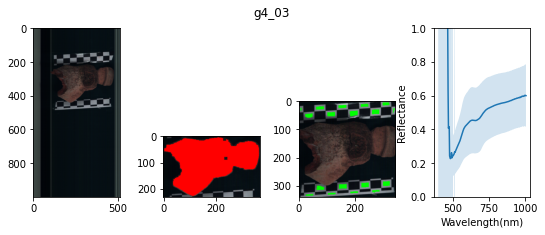

In [17]:
histograms.append(openAndCrop("./Ceramica/g4/g4_03/1_A/"))

### Modern ceramics

C:\Users\pcano\Anaconda3\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


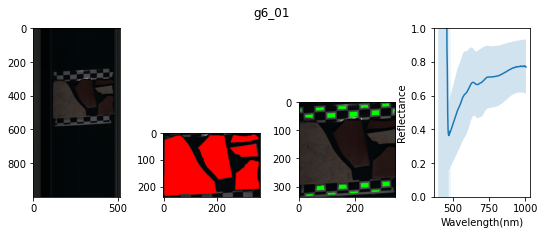

In [18]:
histograms.append(openAndCrop("./Ceramica/g6/g6_01/1_A/"))

C:\Users\pcano\Anaconda3\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


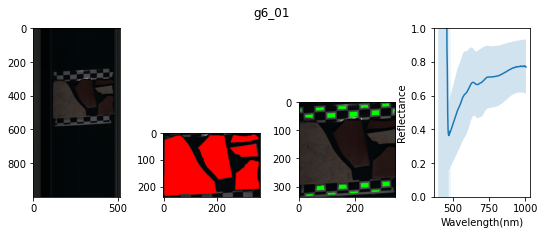

In [19]:
histograms.append(openAndCrop("./Ceramica/g6/g6_01/1_A/"))

C:\Users\pcano\Anaconda3\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


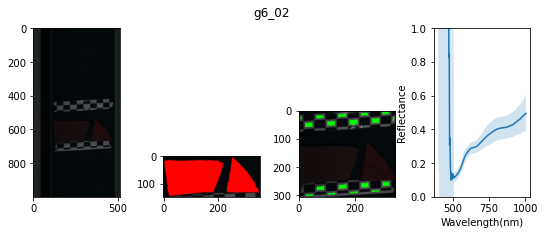

In [20]:
histograms.append(openAndCrop("./Ceramica/g6/g6_02/1_A/"))

C:\Users\pcano\Anaconda3\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


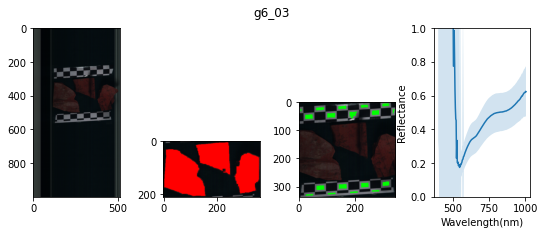

In [21]:
histograms.append(openAndCrop("./Ceramica/g6/g6_03/1_A/"))

## Histogram comparison

In [22]:
sigma = 2

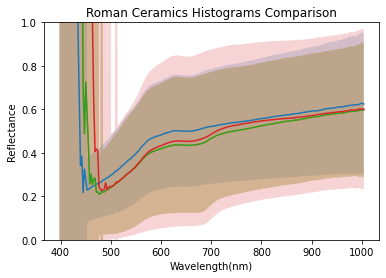

In [23]:
for romanHistogram in histograms[7:11]:
    plt.plot(romanHistogram[0],romanHistogram[1])
    plt.fill_between(romanHistogram[0],romanHistogram[1]-romanHistogram[2]*sigma,romanHistogram[1]+romanHistogram[2]*sigma, alpha = 0.2)
plt.title("Roman Ceramics Histograms Comparison")
plt.ylim([0,1])
plt.xlabel("Wavelength(nm)")
plt.ylabel("Reflectance")
plt.show()

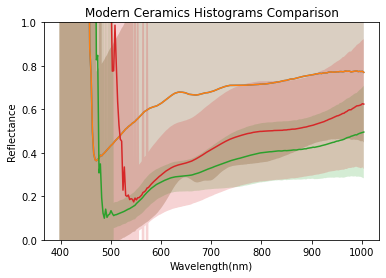

In [24]:
for modernHistogram in histograms[11:]:
    plt.plot(modernHistogram[0],modernHistogram[1])
    plt.fill_between(modernHistogram[0],modernHistogram[1]-modernHistogram[2]*sigma,modernHistogram[1]+modernHistogram[2]*sigma, alpha = 0.2)
plt.title("Modern Ceramics Histograms Comparison")
plt.ylim([0,1])
plt.xlabel("Wavelength(nm)")
plt.ylabel("Reflectance")
plt.show()

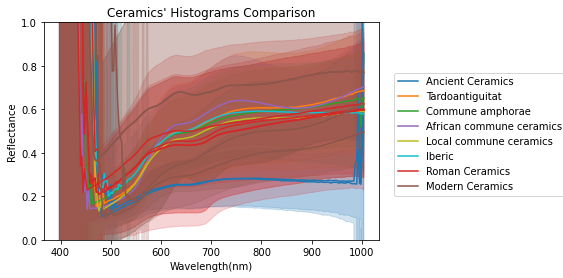

In [25]:
for ancientHistogram in histograms[:2-1]:
    plt.plot(ancientHistogram[0],ancientHistogram[1],mcolors.TABLEAU_COLORS["tab:blue"])
    plt.fill_between(ancientHistogram[0],ancientHistogram[1]-ancientHistogram[2]*sigma,ancientHistogram[1]+ancientHistogram[2]*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:blue"])
for ancientHistogram in histograms[2-1:2]:
    plt.plot(ancientHistogram[0],ancientHistogram[1],mcolors.TABLEAU_COLORS["tab:blue"],label="Ancient Ceramics")
    plt.fill_between(ancientHistogram[0],ancientHistogram[1]-ancientHistogram[2]*sigma,ancientHistogram[1]+ancientHistogram[2]*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:blue"])
for ancientHistogram in histograms[2:3]:
    plt.plot(ancientHistogram[0],ancientHistogram[1],mcolors.TABLEAU_COLORS["tab:orange"],label="Tardoantiguitat")
    plt.fill_between(ancientHistogram[0],ancientHistogram[1]-ancientHistogram[2]*sigma,ancientHistogram[1]+ancientHistogram[2]*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:orange"])
for ancientHistogram in histograms[3:4]:
    plt.plot(ancientHistogram[0],ancientHistogram[1],mcolors.TABLEAU_COLORS["tab:green"],label="Commune amphorae")
    plt.fill_between(ancientHistogram[0],ancientHistogram[1]-ancientHistogram[2]*sigma,ancientHistogram[1]+ancientHistogram[2]*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:green"])
for ancientHistogram in histograms[4:5]:
    plt.plot(ancientHistogram[0],ancientHistogram[1],mcolors.TABLEAU_COLORS["tab:purple"],label="African commune ceramics")
    plt.fill_between(ancientHistogram[0],ancientHistogram[1]-ancientHistogram[2]*sigma,ancientHistogram[1]+ancientHistogram[2]*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:purple"])
for ancientHistogram in histograms[5:6]:
    plt.plot(ancientHistogram[0],ancientHistogram[1],mcolors.TABLEAU_COLORS["tab:olive"],label="Local commune ceramics ")
    plt.fill_between(ancientHistogram[0],ancientHistogram[1]-ancientHistogram[2]*sigma,ancientHistogram[1]+ancientHistogram[2]*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:olive"])
for ancientHistogram in histograms[6:7]:
    plt.plot(ancientHistogram[0],ancientHistogram[1],mcolors.TABLEAU_COLORS["tab:cyan"],label="Iberic")
    plt.fill_between(ancientHistogram[0],ancientHistogram[1]-ancientHistogram[2]*sigma,ancientHistogram[1]+ancientHistogram[2]*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:cyan"])
for romanHistogram in histograms[7:11-1]:
    plt.plot(romanHistogram[0],romanHistogram[1],mcolors.TABLEAU_COLORS["tab:red"])
    plt.fill_between(romanHistogram[0],romanHistogram[1]-romanHistogram[2]*sigma,romanHistogram[1]+romanHistogram[2]*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:red"])
for romanHistogram in histograms[11-1:11]:
    plt.plot(romanHistogram[0],romanHistogram[1],mcolors.TABLEAU_COLORS["tab:red"],label="Roman Ceramics")
    plt.fill_between(romanHistogram[0],romanHistogram[1]-romanHistogram[2]*sigma,romanHistogram[1]+romanHistogram[2]*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:red"])
for modernHistogram in histograms[11:-1]:
    plt.plot(modernHistogram[0],modernHistogram[1],mcolors.TABLEAU_COLORS["tab:brown"])
    plt.fill_between(modernHistogram[0],modernHistogram[1]-modernHistogram[2]*sigma,modernHistogram[1]+modernHistogram[2]*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:brown"])
for modernHistogram in histograms[-1:]:
    plt.plot(modernHistogram[0],modernHistogram[1],mcolors.TABLEAU_COLORS["tab:brown"],label="Modern Ceramics")
    plt.fill_between(modernHistogram[0],modernHistogram[1]-modernHistogram[2]*sigma,modernHistogram[1]+modernHistogram[2]*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:brown"])
plt.title("Ceramics' Histograms Comparison")
plt.ylim([0,1])
plt.xlabel("Wavelength(nm)")
plt.ylabel("Reflectance")
plt.figlegend(loc='center left', bbox_to_anchor=(0.9, 0.5))
plt.show()

## Category Analysis

All the samples of each category are analyzed, and the resulting values aggregated by category, allowing a cleaner approach than using individual samples and histograms

In [26]:
modernValues = np.empty((0,224))
romanValues = np.empty((0,224))
TardoAntiguitatValues = np.empty((0,224))
IberiquesValues = np.empty((0,224))
bands = openAndCrop("./Ceramica/g6/g6_01/1_A/",showImages=False)[0]

C:\Users\pcano\Anaconda3\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


In [27]:

modernValues = np.empty((0,224))
#modernValues = np.concatenate((modernValues,openAndCrop("./Ceramica/g6/g6_01/1_A/",showImages=False)[3]))
#modernValues = np.concatenate((modernValues,openAndCrop("./Ceramica/g6/g6_01/1_B/",showImages=False)[3]))
modernValues = np.concatenate((modernValues,openAndCrop("./Ceramica/g6/g6_02/1_A/",showImages=False)[3]))
modernValues = np.concatenate((modernValues,openAndCrop("./Ceramica/g6/g6_02/1_B/",showImages=False)[3]))
modernValues = np.concatenate((modernValues,openAndCrop("./Ceramica/g6/g6_02/2_A/",showImages=False)[3]))
modernValues = np.concatenate((modernValues,openAndCrop("./Ceramica/g6/g6_02/2_B/",showImages=False)[3]))
modernValues = np.concatenate((modernValues,openAndCrop("./Ceramica/g6/g6_03/1_A/",showImages=False)[3]))
#modernValues = np.concatenate((modernValues,openAndCrop("./Ceramica/g6/g6_03/1_B/",showImages=False)[3]))
#modernValues = np.concatenate((modernValues,openAndCrop("./Ceramica/g6/g6_03/2_A/",showImages=False)[3]))
#modernValues = np.concatenate((modernValues,openAndCrop("./Ceramica/g6/g6_03/2_B/",showImages=False)[3]))
#modernValues = np.concatenate((modernValues,openAndCrop("./Ceramica/g6/g6_03/3_A/",showImages=False)[3]))
#modernValues = np.concatenate((modernValues,openAndCrop("./Ceramica/g6/g6_03/3_B/",showImages=False)[3]))

In [28]:
romanValues = np.concatenate((romanValues,openAndCrop("./Ceramica/g4/g4_01/1_A/",showImages=False)[3]))
romanValues = np.concatenate((romanValues,openAndCrop("./Ceramica/g4/g4_01/1_B/",showImages=False)[3]))
romanValues = np.concatenate((romanValues,openAndCrop("./Ceramica/g4/g4_02/1_A/",showImages=False)[3]))
romanValues = np.concatenate((romanValues,openAndCrop("./Ceramica/g4/g4_02/1_B/",showImages=False)[3]))
romanValues = np.concatenate((romanValues,openAndCrop("./Ceramica/g4/g4_03/1_A/",showImages=False)[3]))
romanValues = np.concatenate((romanValues,openAndCrop("./Ceramica/g4/g4_03/1_B/",showImages=False)[3]))

In [29]:
TardoAntiguitatValues = np.concatenate((TardoAntiguitatValues,openAndCrop("./Ceramica/g3/g3_01/1_A/",showImages=False)[3]))
TardoAntiguitatValues = np.concatenate((TardoAntiguitatValues,openAndCrop("./Ceramica/g3/g3_01/1_B/",showImages=False)[3]))

In [30]:
#IberiquesValues = np.concatenate((IberiquesValues,openAndCrop("./Ceramica/g2/g2_01/1_A/",showImages=False)[3]))
#IberiquesValues = np.concatenate((IberiquesValues,openAndCrop("./Ceramica/g2/g2_01/1_B/",showImages=False)[3]))
#IberiquesValues = np.concatenate((IberiquesValues,openAndCrop("./Ceramica/g2/g2_02/1_A/",showImages=False)[3]))
#IberiquesValues = np.concatenate((IberiquesValues,openAndCrop("./Ceramica/g2/g2_02/1_B/",showImages=False)[3]))
IberiquesValues = np.concatenate((IberiquesValues,openAndCrop("./Ceramica/g2/g2_03/1_A/",showImages=False)[3]))
IberiquesValues = np.concatenate((IberiquesValues,openAndCrop("./Ceramica/g2/g2_03/1_B/",showImages=False)[3]))
IberiquesValues = np.concatenate((IberiquesValues,openAndCrop("./Ceramica/g2/g2_04/1_A/",showImages=False)[3]))
IberiquesValues = np.concatenate((IberiquesValues,openAndCrop("./Ceramica/g2/g2_04/1_B/",showImages=False)[3]))
IberiquesValues = np.concatenate((IberiquesValues,openAndCrop("./Ceramica/g2/g2_04/2_A/",showImages=False)[3]))
IberiquesValues = np.concatenate((IberiquesValues,openAndCrop("./Ceramica/g2/g2_04/2_B/",showImages=False)[3]))
IberiquesValues = np.concatenate((IberiquesValues,openAndCrop("./Ceramica/g2/g2_04/3_A/",showImages=False)[3]))
IberiquesValues = np.concatenate((IberiquesValues,openAndCrop("./Ceramica/g2/g2_04/3_B/",showImages=False)[3]))

In [31]:
modernMean = np.array([np.mean(modernValues[:,x]) for x in range(modernValues.shape[1])])
modernStd = np.array([np.std(modernValues[:,x]) for x in range(modernValues.shape[1])])
romanMean = np.array([np.mean(romanValues[:,x]) for x in range(romanValues.shape[1])])
romanStd = np.array([np.std(romanValues[:,x]) for x in range(romanValues.shape[1])])
tardoMean = np.array([np.mean(TardoAntiguitatValues[:,x]) for x in range(TardoAntiguitatValues.shape[1])])
tardoStd = np.array([np.std(TardoAntiguitatValues[:,x]) for x in range(TardoAntiguitatValues.shape[1])])
iberMean = np.array([np.mean(IberiquesValues[:,x]) for x in range(IberiquesValues.shape[1])])
iberStd = np.array([np.std(IberiquesValues[:,x]) for x in range(IberiquesValues.shape[1])])

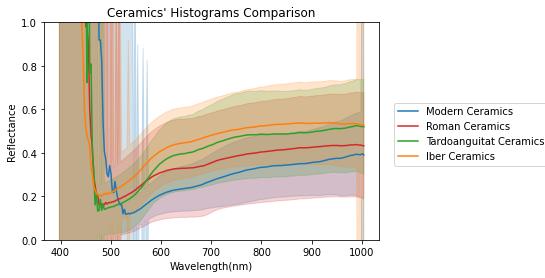

In [32]:
plt.plot(bands,modernMean,mcolors.TABLEAU_COLORS["tab:blue"], label="Modern Ceramics")
plt.fill_between(bands,modernMean-modernStd*sigma,modernMean+modernStd*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:blue"])

plt.plot(bands,romanMean,mcolors.TABLEAU_COLORS["tab:red"], label="Roman Ceramics")
plt.fill_between(bands,romanMean-romanStd*sigma,romanMean+romanStd*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:red"])

plt.plot(bands,tardoMean,mcolors.TABLEAU_COLORS["tab:green"], label="Tardoanguitat Ceramics")
plt.fill_between(bands,tardoMean-tardoStd*sigma,tardoMean+tardoStd*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:green"])

plt.plot(bands,iberMean,mcolors.TABLEAU_COLORS["tab:orange"], label="Iber Ceramics")
plt.fill_between(bands,iberMean-iberStd*sigma,iberMean+iberStd*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:orange"])

plt.title("Ceramics' Histograms Comparison")
plt.ylim([0,1])
plt.xlabel("Wavelength(nm)")
plt.ylabel("Reflectance")
plt.figlegend(loc='center left', bbox_to_anchor=(0.9, 0.5))
plt.show()

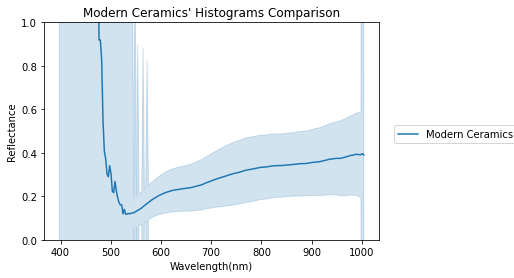

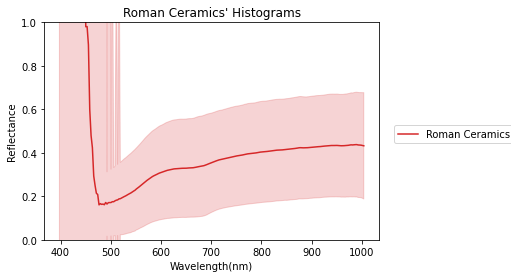

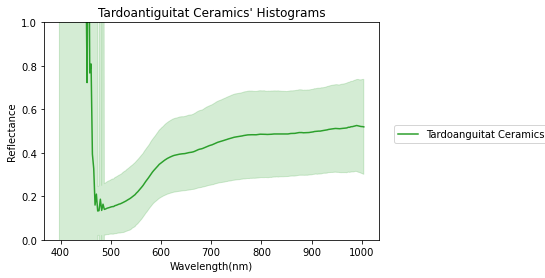

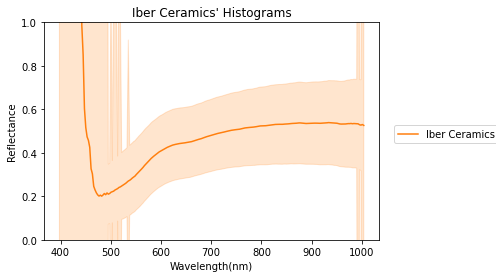

In [33]:
plt.plot(bands,modernMean,mcolors.TABLEAU_COLORS["tab:blue"], label="Modern Ceramics")
plt.fill_between(bands,modernMean-modernStd*sigma,modernMean+modernStd*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:blue"])


plt.title("Modern Ceramics' Histograms Comparison")
plt.ylim([0,1])
plt.xlabel("Wavelength(nm)")
plt.ylabel("Reflectance")
plt.figlegend(loc='center left', bbox_to_anchor=(0.9, 0.5))
plt.show()


plt.plot(bands,romanMean,mcolors.TABLEAU_COLORS["tab:red"], label="Roman Ceramics")
plt.fill_between(bands,romanMean-romanStd*sigma,romanMean+romanStd*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:red"])

plt.title("Roman Ceramics' Histograms")
plt.ylim([0,1])
plt.xlabel("Wavelength(nm)")
plt.ylabel("Reflectance")
plt.figlegend(loc='center left', bbox_to_anchor=(0.9, 0.5))
plt.show()

plt.plot(bands,tardoMean,mcolors.TABLEAU_COLORS["tab:green"], label="Tardoanguitat Ceramics")
plt.fill_between(bands,tardoMean-tardoStd*sigma,tardoMean+tardoStd*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:green"])

plt.title("Tardoantiguitat Ceramics' Histograms")
plt.ylim([0,1])
plt.xlabel("Wavelength(nm)")
plt.ylabel("Reflectance")
plt.figlegend(loc='center left', bbox_to_anchor=(0.9, 0.5))
plt.show()

plt.plot(bands,iberMean,mcolors.TABLEAU_COLORS["tab:orange"], label="Iber Ceramics")
plt.fill_between(bands,iberMean-iberStd*sigma,iberMean+iberStd*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:orange"])

plt.title("Iber Ceramics' Histograms")
plt.ylim([0,1])
plt.xlabel("Wavelength(nm)")
plt.ylabel("Reflectance")
plt.figlegend(loc='center left', bbox_to_anchor=(0.9, 0.5))
plt.show()

In [34]:
modernCurve = []
for i in range(len(bands)):
    modernCurve.append((bands[i],modernMean[i]+modernStd[i]*sigma))
for i in reversed(range(len(bands))):
    modernCurve.append((bands[i],modernMean[i]-modernStd[i]*sigma))
    
romanCurve = []
for i in range(len(bands)):
    romanCurve.append((bands[i],romanMean[i]+romanStd[i]*sigma))
for i in reversed(range(len(bands))):
    romanCurve.append((bands[i],romanMean[i]-romanStd[i]*sigma))
    
tardoCurve = []
for i in range(len(bands)):
    tardoCurve.append((bands[i],tardoMean[i]+tardoStd[i]*sigma))
for i in reversed(range(len(bands))):
    tardoCurve.append((bands[i],tardoMean[i]-tardoStd[i]*sigma))
    
iberCurve = []
for i in range(len(bands)):
    iberCurve.append((bands[i],iberMean[i]+iberStd[i]*sigma))
for i in reversed(range(len(bands))):
    iberCurve.append((bands[i],iberMean[i]-iberStd[i]*sigma))

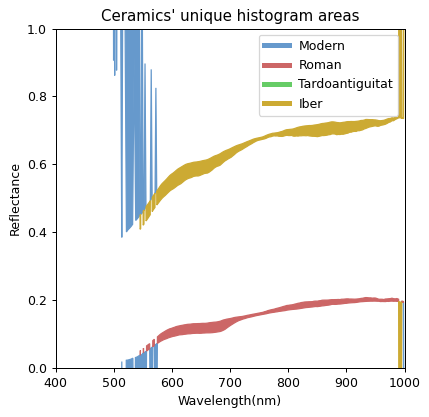

In [35]:
polygons = []
polygons.append(Polygon(modernCurve))
polygons.append(Polygon(romanCurve))
polygons.append(Polygon(tardoCurve))
polygons.append(Polygon(iberCurve))
BLUE="#6699cc"
RED="#cc6666"
GREEN="#66cc66"
ORANGE="#ccaa33"
dif0 = polygons[0].difference(polygons[1]).difference(polygons[2]).difference(polygons[3])
patch0 = PolygonPatch(dif0, fc=BLUE, ec=BLUE)
dif1 = polygons[1].difference(polygons[0]).difference(polygons[2]).difference(polygons[3])
patch1 = PolygonPatch(dif1, fc=RED, ec=RED)
dif2 = polygons[2].difference(polygons[0]).difference(polygons[1]).difference(polygons[3])
patch2 = PolygonPatch(dif2, fc=GREEN, ec=GREEN)
dif3 = polygons[3].difference(polygons[0]).difference(polygons[1]).difference(polygons[2])
patch3 = PolygonPatch(dif3, fc=ORANGE, ec=ORANGE)

fig = plt.figure(1, figsize=(5,5), dpi=90)

ax = fig.add_subplot(111)
ax.add_patch(patch0)
ax.add_patch(patch1)
ax.add_patch(patch2)
ax.add_patch(patch3)
plt.ylim([0,1])
plt.xlim([400,1000])

plt.xlabel("Wavelength(nm)")
plt.ylabel("Reflectance")
plt.title("Ceramics' unique histogram areas")
custom_lines = [Line2D([0], [0], color=BLUE, lw=4),
                Line2D([0], [0], color=RED, lw=4),
                Line2D([0], [0], color=GREEN, lw=4),
                Line2D([0], [0], color=ORANGE, lw=4)]
ax.legend(custom_lines, ['Modern', 'Roman', 'Tardoantiguitat', 'Iber'])
plt.show()

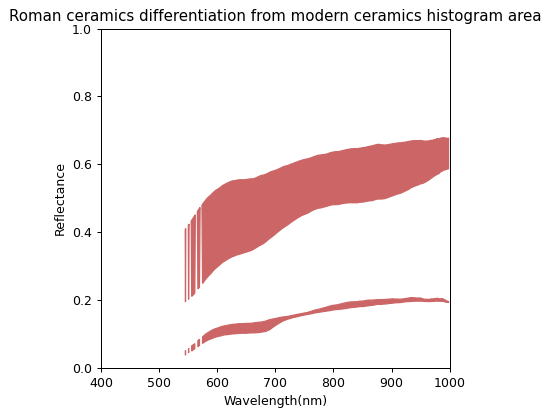

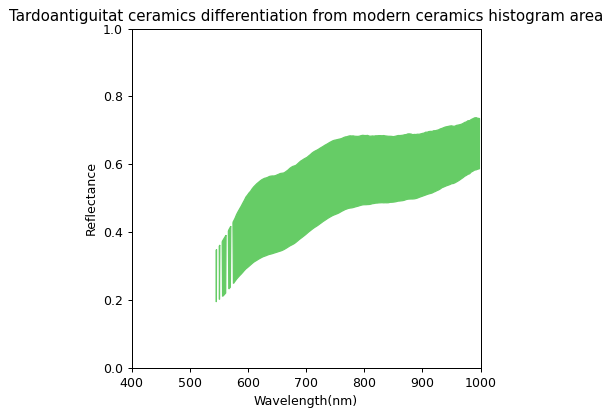

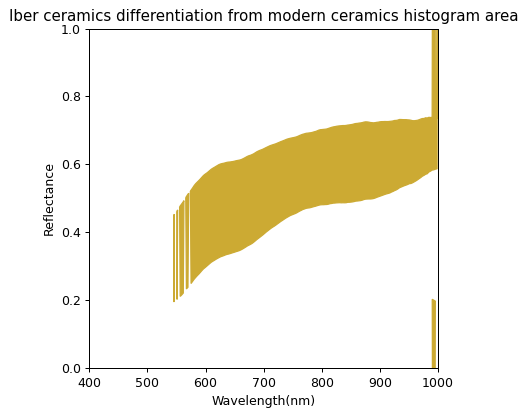

In [36]:

dif1 = polygons[1].difference(polygons[0])
patch1 = PolygonPatch(dif1, fc=RED, ec=RED)
dif2 = polygons[2].difference(polygons[0])
patch2 = PolygonPatch(dif2, fc=GREEN, ec=GREEN)
dif3 = polygons[3].difference(polygons[0])
patch3 = PolygonPatch(dif3, fc=ORANGE, ec=ORANGE)

fig = plt.figure(1, figsize=(5,5), dpi=90)

ax = fig.add_subplot(111)
ax.add_patch(patch1)
plt.ylim([0,1])
plt.xlim([400,1000])
plt.xlabel("Wavelength(nm)")
plt.ylabel("Reflectance")
plt.title("Roman ceramics differentiation from modern ceramics histogram area")
plt.show()

fig = plt.figure(1, figsize=(5,5), dpi=90)
ax = fig.add_subplot(111)
ax.add_patch(patch2)
plt.ylim([0,1])
plt.xlim([400,1000])
plt.xlabel("Wavelength(nm)")
plt.ylabel("Reflectance")
plt.title("Tardoantiguitat ceramics differentiation from modern ceramics histogram area")
plt.show()

fig = plt.figure(1, figsize=(5,5), dpi=90)
ax = fig.add_subplot(111)
ax.add_patch(patch3)
plt.ylim([0,1])
plt.xlim([400,1000])
plt.xlabel("Wavelength(nm)")
plt.ylabel("Reflectance")
plt.title("Iber ceramics differentiation from modern ceramics histogram area")
plt.show()